#**Long-Short Term Memory (LSTM)**

***Prepared by:*** [**Manisa Pipattanasomporn**](https://mpipatta.github.io)

*Created: January 2, 2020 (updated April 5, 2020)*

LSTM is a deep learning family. In this tutorial, we will use LSTM to perform hour-ahead load forecasting when historical load data are inputs to the forecasting model.

We will use keras library.




---


#**Step 1: Load Data**

Again, this notebook will work with "Bangkok.csv", the electrical consumption of a building at one-hour intervals for one year.

In [1]:
%tensorflow_version 1.x
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
np.random.seed(7)

TensorFlow 1.x selected.


Using TensorFlow backend.


In [2]:
url ='https://raw.githubusercontent.com/mpipatta/mpipatta.github.io/master/testdata/Bangkok.csv'
df = pd.read_csv(url, index_col=[0], parse_dates=[0])[['Load','Outdoor']]
df.head(5)
#We will parse the first column (col=[0]) as the index column as the date. 
#The 'Load' column will be saved in the dataframe df.
#Note: the 'Load' is in kilo-Watt (kW).

,Load,Outdoor
Time,,
2016-01-01 00:00:00,4.30,80.5
2016-01-01 01:00:00,4.12,79.2
2016-01-01 02:00:00,4.06,79.1
2016-01-01 03:00:00,4.44,79.0
2016-01-01 04:00:00,3.88,78.8


In [3]:
df['Lt-1'] = df['Load'].shift(1)
df['W']=df.index.dayofweek
df['H']=df.index.hour
df.head()

,Load,Outdoor,Lt-1,W,H
Time,,,,,
2016-01-01 00:00:00,4.30,80.5,NaN,4,0
2016-01-01 01:00:00,4.12,79.2,4.30,4,1
2016-01-01 02:00:00,4.06,79.1,4.12,4,2
2016-01-01 03:00:00,4.44,79.0,4.06,4,3
2016-01-01 04:00:00,3.88,78.8,4.44,4,4


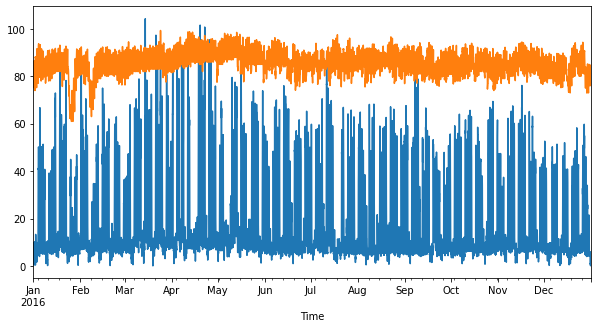

In [4]:
plt.figure(figsize=(10,5))
df['Load'].plot()
df['Outdoor'].plot()

#**Step 2: Prepare Data**

### **a) Normalize the dataset**

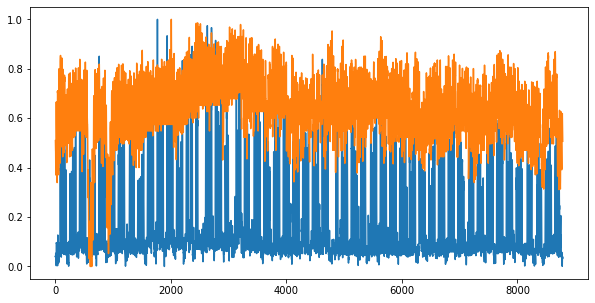

In [5]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
data=scaler.fit_transform(df)

plt.figure(figsize=(10,5))
plt.plot(data[:,0])
plt.plot(data[:,1])

### **b) Split into train vs test datasets**

In [6]:
# split into train and test sets
n = int(len(data)*0.8)
trainY = data[1:n,0]  #(starting from row1 to remove nan value) 
trainX = data[1:n,1:] 
testY = data[n:len(data),0]
testX = data[n:len(data),1:]

print(trainY.shape)
print(trainX.shape)
print('=====Outdoor=======Lt-1=======W=======H========Lt====')
for i in range(5):
  print(trainX[i], trainY[i])

print(testY.shape)
print(testX.shape)
print('=====Outdoor=======Lt-1=======W=======H========Lt====')
for i in range(5):
  print(testX[i,:], testY[i])

(7026,)
(7026, 4)
=====Outdoor=======Lt-1=======W=======H========Lt====
[0.47519582 0.04069488 0.66666667 0.04347826] 0.038967271331221805
[0.47258486 0.03896727 0.66666667 0.08695652] 0.0383914003263269
[0.46997389 0.0383914  0.66666667 0.13043478] 0.04203858335732796
[0.46475196 0.04203858 0.66666667 0.17391304] 0.036663787311642194
[0.4308094  0.03666379 0.66666667 0.2173913 ] 0.053364046453594396
(1757,)
(1757, 4)
=====Outdoor=======Lt-1=======W=======H========Lt====
[0.63133159 0.14224014 0.33333333 0.82608696] 0.058162971494385256
[0.62663185 0.05816297 0.33333333 0.86956522] 0.055859487474805646
[0.62663185 0.05585949 0.33333333 0.91304348] 0.08215759669833955
[0.60052219 0.0821576  0.33333333 0.95652174] 0.08167770419426049
[0.60052219 0.0816777  0.33333333 1.        ] 0.07860639216815432


### **c) Reshape for inputting into the LSTM model**
Since LSTM requires in the form of [samples, timesteps, features], we converted the 2d input to 3d input.

samples are the number of datapoints you have.
timesteps is how many prior timesteps being considered.
features is the number of input features (outdoor temperature, historical loads, weekday, day, hour, etc... )

In [7]:
# reshape input to be [samples, time steps, features]
trainX = trainX.reshape((trainX.shape[0], 1, 4))
testX = testX.reshape((testX.shape[0], 1, 4))
print('trainX.shape=', trainX.shape)
print('testX.shape=', testX.shape)

trainX.shape= (7026, 1, 4)
testX.shape= (1757, 1, 4)


# **Step 3: Formulate LSTM model**

In [8]:
from keras.optimizers import Adam
opt = Adam(lr=0.005)

model = Sequential()
model.add(LSTM(6, activation='sigmoid',return_sequences=True, input_shape=(1, 4)))
model.add(LSTM(6, activation='sigmoid', input_shape=(1, 4)))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer=opt)
history = model.fit(trainX, trainY, validation_split=0.1, epochs=300, batch_size=24, verbose=1)





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 6323 samples, validate on 703 samples
Epoch 1/300





6323/6323 [==============================] - 4s 600us/step - loss: 0.0341 - val_loss: 0.0204
Epoch 2/300
6323/6323 [==============================] - 2s 260us/step - loss: 0.0182 - val_loss: 0.0054
Epoch 3/300
6323/6323 [==============================] - 1s 207us/step - loss: 0.0050 - val_loss: 0.0030
Epoch 4/300
6323/6323 [==============================] - 1s 234us/step - loss: 0.0035 - val_loss: 0.0026
Epoch 5/300
6323/6323 [==============================] - 1s 216us/step - loss: 0.0030 - val_loss: 0.0023
Epoch 6/300
6323/6323 [==============================] - 1s 212us/step - loss: 0.0027 - val_loss: 0.0021
Epoch 7/300
6323/6323 [==============================] - 1s 222us/step - loss: 0.0025 - val_loss: 0.0019
Epoch 8/300
6323/6323 [==============================] - 1s 195us/step - loss: 0.0024 - val_loss: 0.0018
Epoch 9

# **Step 4: Predict and calculate RMSE**

In [0]:
#predict the load
testPredict = model.predict(testX)

In [0]:
#denormalize the test set
testY_dn = testY*(df['Load'].max()-df['Load'].min())+df['Load'].min()  

#denormalize the prediction
testPredict_dn = testPredict*(df['Load'].max()-df['Load'].min())+df['Load'].min()

In [11]:
print(testY_dn.shape)
print(testPredict_dn.shape)
#print(testPredict_dn.ravel().shape)

(1757,)
(1757, 1)


RMSE= 3.4067862578865666
MAPE= 25.640143360327798


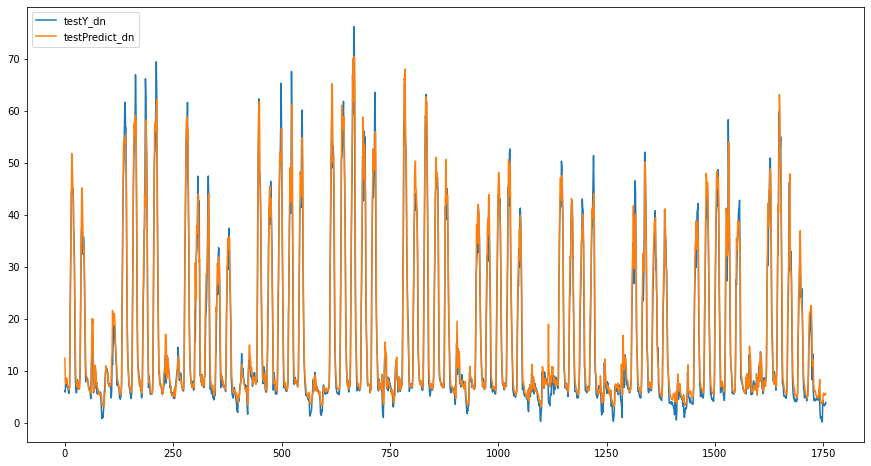

In [12]:
#plot testY vs testPredict
plt.figure(figsize=(15,8))
plt.plot(testY_dn, label='testY_dn')
plt.plot(testPredict_dn, label='testPredict_dn')
plt.legend(loc='upper left')

#calculate RMSE and MAPE
RMSE = np.sqrt(np.mean(np.square(testY_dn-testPredict_dn.ravel())))
MAPE = np.mean(np.abs((testY_dn-testPredict_dn.ravel())/testY_dn))*100

print('RMSE=',RMSE)
print('MAPE=',MAPE)

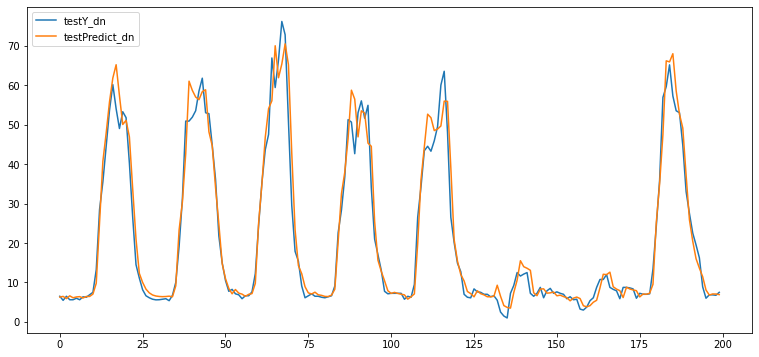

In [13]:
plt.figure(figsize=(13,6))
plt.plot(testY_dn[600:800], label='testY_dn')
plt.plot(testPredict_dn[600:800], label='testPredict_dn')
plt.legend(loc='upper left')

###**Step 5: Check model loss and validation loss**

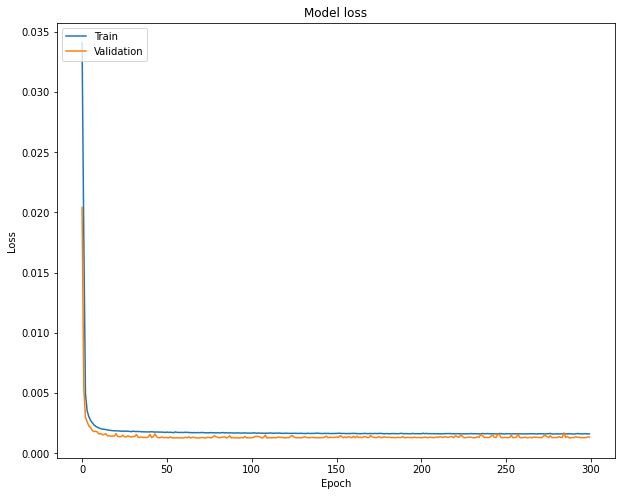

In [14]:
#Check model loss and validation loss
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()